In [7]:
import numpy as np
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib


In [8]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print (get_available_gpus())


['/device:GPU:0']


In [9]:

# Đường dẫn đến thư mục train và test
train_dir = r'train'
test_dir = r'test'

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator từ thư mục train và test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# Hiển thị số lượng mẫu trong mỗi lớp cho tập huấn luyện
train_class_counts = np.bincount(train_generator.classes)
for emotion, count in zip(train_generator.class_indices, train_class_counts):
    print(f'Train - {emotion}: {count}')

# Hiển thị số lượng mẫu trong mỗi lớp cho tập kiểm tra
test_class_counts = np.bincount(test_generator.classes)
for emotion, count in zip(test_generator.class_indices, test_class_counts):
    print(f'Test - {emotion}: {count}')

# Hiển thị dạng one-hot của mỗi lớp
for emotion, index in train_generator.class_indices.items():
    one_hot = tf.keras.utils.to_categorical(index, num_classes=len(train_generator.class_indices))
    print(f'{emotion}: {one_hot}')


Train - angry: 3995
Train - disgusted: 436
Train - fearful: 4097
Train - happy: 7215
Train - neutral: 4965
Train - sad: 4830
Train - surprised: 3171
Test - angry: 958
Test - disgusted: 111
Test - fearful: 1024
Test - happy: 1774
Test - neutral: 1233
Test - sad: 1247
Test - surprised: 831
angry: [1. 0. 0. 0. 0. 0. 0.]
disgusted: [0. 1. 0. 0. 0. 0. 0.]
fearful: [0. 0. 1. 0. 0. 0. 0.]
happy: [0. 0. 0. 1. 0. 0. 0.]
neutral: [0. 0. 0. 0. 1. 0. 0.]
sad: [0. 0. 0. 0. 0. 1. 0.]
surprised: [0. 0. 0. 0. 0. 0. 1.]


In [11]:
print (train_generator.class_indices)

{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [12]:
def print_data_shape(generator): # oke, ta đã có kích thước cho mỗi traain hoặc test là 48x48x3
    print(f'Data shape: {generator.image_shape}')

print_data_shape(train_generator)
print_data_shape(test_generator)


Data shape: (48, 48, 3)
Data shape: (48, 48, 3)


In [13]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2


In [14]:
input_shape=train_generator.image_shape
print (input_shape)

(48, 48, 3)


In [15]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(input_shape=(48, 48, 3), filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
                #  input_shape=train_generator.image_shape))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(7, activation='softmax'))

In [16]:
batch_size = 32
epochs = 300
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
with (tf.device(get_available_gpus()[0])): # 1070ti 
    history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=2)


Epoch 1/300
898/898 - 37s - loss: 2.5964 - accuracy: 0.2693 - val_loss: 1.7285 - val_accuracy: 0.3753 - lr: 5.0000e-04 - 37s/epoch - 42ms/step
Epoch 2/300
898/898 - 32s - loss: 1.9765 - accuracy: 0.3759 - val_loss: 1.5824 - val_accuracy: 0.4326 - lr: 5.0000e-04 - 32s/epoch - 36ms/step
Epoch 3/300
898/898 - 32s - loss: 1.7411 - accuracy: 0.4402 - val_loss: 1.4404 - val_accuracy: 0.4873 - lr: 5.0000e-04 - 32s/epoch - 36ms/step
Epoch 4/300
898/898 - 32s - loss: 1.5910 - accuracy: 0.4782 - val_loss: 1.4326 - val_accuracy: 0.5063 - lr: 5.0000e-04 - 32s/epoch - 35ms/step
Epoch 5/300
898/898 - 31s - loss: 1.4334 - accuracy: 0.5098 - val_loss: 1.3118 - val_accuracy: 0.5488 - lr: 5.0000e-04 - 31s/epoch - 34ms/step
Epoch 6/300
898/898 - 32s - loss: 1.3396 - accuracy: 0.5457 - val_loss: 1.2939 - val_accuracy: 0.5571 - lr: 5.0000e-04 - 32s/epoch - 36ms/step
Epoch 7/300
898/898 - 32s - loss: 1.2970 - accuracy: 0.5649 - val_loss: 1.3077 - val_accuracy: 0.5421 - lr: 5.0000e-04 - 32s/epoch - 36ms/step

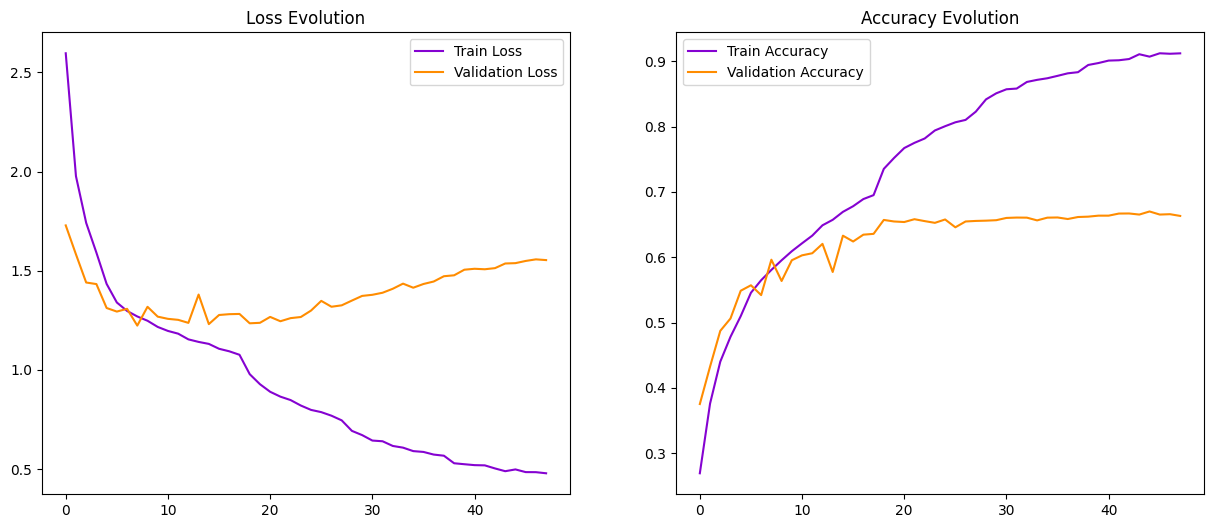

In [17]:

import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()


In [18]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

225/225 [==============================] - 6s 26ms/step - loss: 1.2231 - accuracy: 0.5963

Test Accuracy: 0.5962663888931274
Test Loss:     1.2231231927871704


In [19]:
# from sklearn.metrics import classification_report
# import numpy as np

# # Dự đoán giá trị từ tập test
# y_pred = model.predict(X_test)

# # Chuyển đổi lớp dự đoán thành one hot vectors 
# y_pred_classes = np.argmax(y_pred, axis = 1) 

# # Chuyển đổi quan sát test thành one hot vectors
# y_true = np.argmax(y_test, axis = 1) 

# # Tính toán ma trận nhầm lẫn
# confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# # Tính toán báo cáo phân loại
# classificationReport = classification_report(y_true, y_pred_classes, digits = 3)

# print('Báo cáo phân loại:')
# print(classificationReport)

In [20]:
model.save("my_model_2.h5")